In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report, 
                             confusion_matrix, roc_curve)

In [120]:
df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/data/cleaned_motor_vehicle_collisions.csv')

In [121]:
display(df.head())
display(df.info())

,borough,crash_date,crash_time,day_of_week,month,is_weekend,hour,hour_category,season,pedestrian_involved,cyclist_involved,vehicle_type_code_1,vehicle_type_code_2,contributing_factor_vehicle_1,contributing_factor_vehicle_2,high_risk,KSI
0,Brooklyn,2023-11-01,01:29:00,2,11,0,1,Late_Night,Fall,0,0,MOPED,SEDAN,UNSPECIFIED,UNSPECIFIED,0,0
1,Queens,2022-09-22,16:16:00,3,9,0,16,Evening_Rush,Fall,0,0,SEDAN,E-SCOOTER,PASSING OR LANE USAGE IMPROPER,UNSPECIFIED,0,0
2,Queens,2023-01-12,21:00:00,3,1,0,21,Night,Winter,0,0,STATION WAGON/SPORT UTILITY VEHICLE,UNKNOWN,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,0,0
3,Brooklyn,2022-07-12,17:50:00,1,7,0,17,Evening_Rush,Summer,0,0,SEDAN,UNKNOWN,OVERSIZED VEHICLE,UNSPECIFIED,0,0
4,Brooklyn,2022-04-24,16:45:00,6,4,1,16,Evening_Rush,Spring,0,0,STATION WAGON/SPORT UTILITY VEHICLE,STATION WAGON/SPORT UTILITY VEHICLE,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342418 entries, 0 to 342417
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   borough                        342418 non-null  object
 1   crash_date                     342418 non-null  object
 2   crash_time                     342418 non-null  object
 3   day_of_week                    342418 non-null  int64 
 4   month                          342418 non-null  int64 
 5   is_weekend                     342418 non-null  int64 
 6   hour                           342418 non-null  int64 
 7   hour_category                  342418 non-null  object
 8   season                         342418 non-null  object
 9   pedestrian_involved            342418 non-null  int64 
 10  cyclist_involved               342418 non-null  int64 
 11  vehicle_type_code_1            342418 non-null  object
 12  vehicle_type_code_2            342416 non-nu

None

In [122]:
df.isna().sum() 

borough                          0
crash_date                       0
crash_time                       0
day_of_week                      0
month                            0
is_weekend                       0
hour                             0
hour_category                    0
season                           0
pedestrian_involved              0
cyclist_involved                 0
vehicle_type_code_1              0
vehicle_type_code_2              2
contributing_factor_vehicle_1    0
contributing_factor_vehicle_2    0
high_risk                        0
KSI                              0
dtype: int64

In [123]:
# let's define features for modeling
numerical_features = ['hour', 'day_of_week', 'month']
categorical_features = ['borough', 'hour_category', 'season']

# Le't create a list for binary features
binary_features = ['is_weekend','pedestrian_involved', 'cyclist_involved', 'high_risk']

numerical_features.extend(binary_features)

all_features = numerical_features + categorical_features

In [124]:
# let's define features for modeling
numerical_features = ['hour', 'day_of_week', 'month']
categorical_features = ['borough', 'hour_category', 'season', 'is_weekend','pedestrian_involved', 'cyclist_involved', 'high_risk']
all_features = numerical_features + categorical_features

In [125]:
# Now, let't define the target variable Y, along with features X
X = df[all_features].copy()
y = df['KSI'].copy() # target variable, binary classification

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) # stratify to maintain class balance

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Train KSI rate: {y_train.mean()*100:.2f}%")
print(f"Test KSI rate: {y_test.mean()*100:.2f}%") 


Training set: 273,934 samples
Test set: 68,484 samples
Train KSI rate: 9.01%
Test KSI rate: 9.01%


In [126]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         categorical_features)
    ])

In [127]:
# Let's use all the 10 features for our last model with a different type of classifier (Random Forest)
tuned_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100, 
        max_depth=10,
        min_samples_split=20, 
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

tuned_model.fit(X_train, y_train)
y_pred_tuned = tuned_model.predict(X_test)
y_proba_tuned = tuned_model.predict_proba(X_test)[:, 1]

In [128]:
# Evaluation
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_precision = precision_score(y_test, y_pred_tuned)
tuned_recall = recall_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)
tuned_auc = roc_auc_score(y_test, y_proba_tuned)

In [129]:
print("Baseline Model Performance:")
print(f"Tuned model Accuracy: {tuned_accuracy:.4f}")
print(f"Tuned model Precision: {tuned_precision:.4f}")
print(f"Tuned model Recall: {tuned_recall:.4f}")
print(f"Tuned model F1 Score: {tuned_f1:.4f}")
print(f"Tuned model ROC-AUC: {tuned_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_tuned, zero_division=0))
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_tuned)
print(conf_matrix)

Baseline Model Performance:
Tuned model Accuracy: 0.5671
Tuned model Precision: 0.1160
Tuned model Recall: 0.5746
Tuned model F1 Score: 0.1931
Tuned model ROC-AUC: 0.6022

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.57      0.70     62311
           1       0.12      0.57      0.19      6173

    accuracy                           0.57     68484
   macro avg       0.52      0.57      0.45     68484
weighted avg       0.86      0.57      0.66     68484

Confusion Matrix:
[[35293 27018]
 [ 2626  3547]]


- This model identify identifies 58.1% of KSI cases (recall).
- With 12% precision, most predictions are accurate.
- F1-score of 19% shows good balance between precision and recall.

In [130]:
# Feature importance (get the most important features for the model to perfom and predict well)
feature_names_encoded = (numerical_features + 
                        list(tuned_model.named_steps['preprocessor']
                        .named_transformers_['cat'].get_feature_names_out(categorical_features)))

importances = tuned_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names_encoded,
    'importance': importances
}).sort_values('importance', ascending=False).head(10)

In [131]:
feature_importance_df

,feature,importance
0,hour,0.156224
17,high_risk_1,0.148242
16,cyclist_involved_1,0.121586
4,borough_Manhattan,0.104955
15,pedestrian_involved_1,0.089568
2,month,0.086115
1,day_of_week,0.076965
10,hour_category_Night,0.031752
3,borough_Brooklyn,0.031104
9,hour_category_Morning_Rush,0.022146



--- Confusion Matrix for the tune model ---


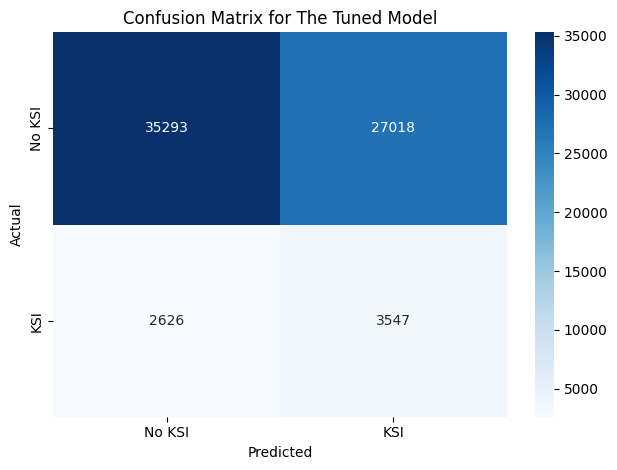

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Confusion Matrix for the tune model ---")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No KSI', 'KSI'], yticklabels=['No KSI', 'KSI'])
plt.title('Confusion Matrix for The Tuned Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
#plt.savefig('/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/figures/tunedmodel_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


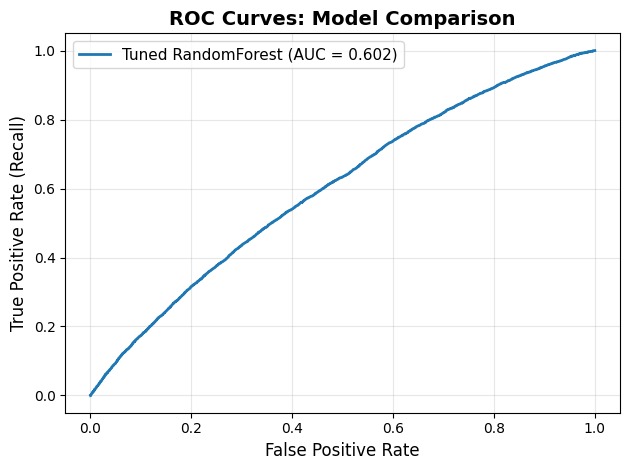

In [135]:
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned RandomForest (AUC = {tuned_auc:.3f})', linewidth=2)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [136]:
df.columns

Index(['borough', 'crash_date', 'crash_time', 'day_of_week', 'month',
       'is_weekend', 'hour', 'hour_category', 'season', 'pedestrian_involved',
       'cyclist_involved', 'vehicle_type_code_1', 'vehicle_type_code_2',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'high_risk', 'KSI'],
      dtype='object')

### Best Model: 
- Based on the result on performance the tuned model is the best to deploy to our stakeholders because:
1. it has a better RECALL whic is very important for Safety
   - the model identifies 58.1% of severe crashes (KSI events)
   - For Vision Zero, catching dangerous collisions is more critical than avoiding false alarms (false positve)
   - Missing a KSI event has severe consequences (deaths/injuries). 
2. BALANCED PERFORMANCE
   - Precision: 0.115 - most predictions are correct
   - F1-Score: 0.192 - good balance
   - ROC-AUC: 0.602 - strong overall discrimination
3. ACTIONABLE INSIGHTS
   - Feature importance shows which factors matter most. Here in our case, `hour`, `high_risk`, `cyclist_involved`, `borough_Manhattan`, `pedestrian_involved ` are the top 5 best features predicting Killed or Serious Injured.
   - Can identify high-risk scenarios for intervention.
4.  DEPLOYMENT
   - This model can predict KSI risk in real-time from crash reports
   - Helps prioritize emergency response
   - Guides resource allocation and policy decisions

#### Final Step:
- let's Pickle the Tuned Model for the App

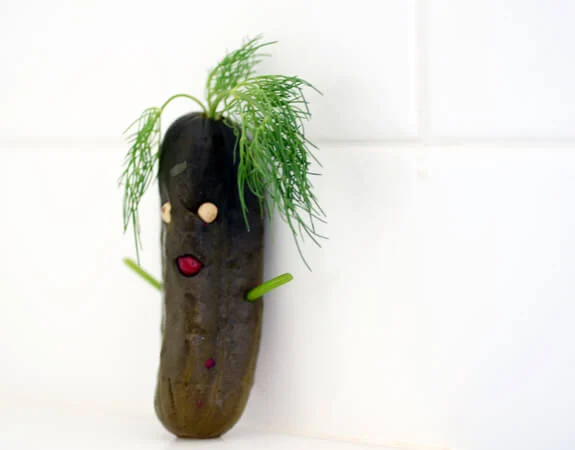

In [163]:
# Save the tuned model
import joblib

joblib.dump(tuned_model, '/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/app/final_model.pkl')

# Save the clustering model and scaler
joblib.dump(kmeans_final, '/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/app/clustering_model.pkl')
joblib.dump(scaler_cluster, '/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/app/clustering_scaler.pkl')

['/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/app/clustering_scaler.pkl']

In [164]:
# Let's create the METADATA for STREAMLIT APP

# Get feature importance for top features
feature_names_encoded = (numerical_features + 
                        list(tuned_model.named_steps['preprocessor']
                        .named_transformers_['cat'].get_feature_names_out(categorical_features)))

In [165]:
importances = tuned_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names_encoded,
    'importance': importances
}).sort_values('importance', ascending=False).head(5)

In [166]:

# Create metadata dictionary for the model to retrieve
meta = {
    "test_accuracy": float(tuned_accuracy),
    "test_recall": float(tuned_recall),
    "test_precision": float(tuned_precision),
    "test_f1": float(tuned_f1),
    "test_auc": float(tuned_auc),
    "boroughs": df['borough'].unique().tolist(),
    "hour_categories": df['hour_category'].unique().tolist(),
    "seasons": df['season'].unique().tolist(),
    "ksi_rate": float(df['KSI'].mean()),
    "total_crashes": int(len(df)),
    "feature_names": all_features,
    "top_features": feature_importance_df.to_dict('records')
}


In [167]:
# Save metadata to JSON file
import json
with open("/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/app/ksi_model_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

### Let's go deploy the App!
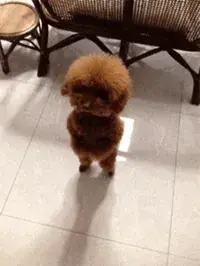